In [1]:
import os
import time
from time import sleep
import logging
import requests
import threading
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from datetime import datetime, timedelta
import matplotlib as plot
import pickle
import math

In [2]:
load_dotenv()

True

Starting Portfolio Value: 10000.00
position size: 0
2019-03-20, Buy 5 shares of stock at 1797.73
2019-03-21, AMZN   Order:   1	Type: Buy  	Status Accepted 	Size:    5.0000 Price: 1797.7300 Position: 5
2019-03-21, AMZN   Order:   1	Type: Buy  	Status Completed 	Size:    5.0000 Price: 1797.7300 Position: 5
2019-03-21, AMZN   BUY   Price: 1796.26 Cost: 8981.30 Comm: 0.00 Size:    5.0000 
2019-09-26, Sell 5 shares of stock at 1740.12
2019-09-27, AMZN   Order:   2	Type: Sell 	Status Accepted 	Size:   -5.0000 Price: 1740.1200 Position: 0
2019-09-27, AMZN   Order:   2	Type: Sell 	Status Completed 	Size:   -5.0000 Price: 1740.1200 Position: 0
2019-09-27, AMZN   SELL  Price: 1747.80 Cost: 8981.30 Comm: 0.00 Size:   -5.0000 
2019-09-27, AMZN Closed: PnL Gross -242.3, Net -242.3,
2020-01-02, Buy 5 shares of stock at 1897.71
2020-01-03, AMZN   Order:   3	Type: Buy  	Status Accepted 	Size:    5.0000 Price: 1897.7100 Position: 5
2020-01-03, AMZN   Order:   3	Type: Buy  	Status Completed 	Size:    5.

<IPython.core.display.Javascript object>


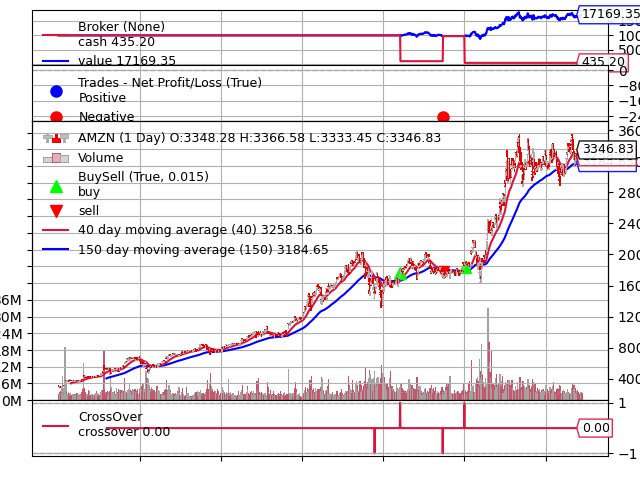

[[<Figure size 640x480 with 5 Axes>]]

In [3]:
import alpaca_backtrader_api
import backtrader as bt
from datetime import datetime

ALPACA_API_KEY = os.getenv('ALPACA_API_KEY')
ALPACA_SECRET_KEY = os.getenv('ALPACA_SECRET_KEY')
ALPACA_PAPER = True

def run_test_macd():
    # with open("sp500tickers.pickle", "rb") as f:
    #     tickers = pickle.load(f)
    tickers = ["AMZN", "FB", "IPDN"]
    for ticker in tickers:
        macd_stock_test2(ticker)
#define strategy

def macd_stock_test2(ticker):
    # print("stock test")
    # print("ticker")
    cerebro = bt.Cerebro()
    cerebro.addstrategy(GoldCross)

    cerebro.broker.set_cash(100000)
    # ticker_prices = pd.read_csv(
    #     "stock_dfs/{}.csv".format(ticker), index_col="Date", parse_dates=True
    # )

    # print(ticker_prices)
    # # ticker prices
    # feed = bt.feeds.PandasData(dataname=ticker_prices)
    # print(feed)
    # print(ticker)
    feed = bt.feeds.YahooFinanceData(
        dataname=ticker,
        timeframe=bt.TimeFrame.Days,
        fromdate=datetime.datetime(2019, 1, 1),
        todate=datetime.datetime(2021, 6, 1),
        reverse=False,
    )
    cerebro.adddata(feed)

    # cerebro.addsizer(bt.sizers.FixedSize, stake=1000)
    # cerebro.addanalyzer(btanalyzers.DrawDown, _name='drawdown')
    # cerebro.addanalyzer(btanalyzers.DrawDown, _name='returns')

    print("starting portfolio value: %.2f" % cerebro.broker.getvalue())
    cerebro.run()
    

    print("final portfolio value: %.2f" % cerebro.broker.getvalue())
    # cerebro.addanalyzer(SQN)
    #
    # cerebro.addwriter(bt.WriterFile, csv=args.writercsv, rounding=2)
    cerebro.plot(style='candle')
    
#create strategy held object
class GoldCross(bt.Strategy):

    # set parameters to define fast and slow
    params = (
        ("fast", 40),
        ("slow", 150),
        ("order_percentage", 0.99),
        ("ticker", "stock"),
    )

    # define constractors
    def __init__(self):
        print("position size:", self.position.size)

        self.fast_moving_average = bt.indicators.EMA(
            self.data.close, period=self.params.fast, plotname="40 day moving average"
        )

        self.slow_moving_average = bt.indicators.EMA(
            self.data.close, period=self.params.slow, plotname="150 day moving average"
        )

        self.crossover = bt.indicators.CrossOver(
            self.fast_moving_average, self.slow_moving_average
        )

    def log(self, txt, dt=None):
        """ Logging function fot this strategy"""
        dt = dt or self.data.datetime[0]
        if isinstance(dt, float):
            dt = bt.num2date(dt)
        print("%s, %s" % (dt.date(), txt))

    def notify_order(self, order):
        """ Triggered upon changes to orders. """

        # Suppress notification if it is just a submitted order.
        if order.status == order.Submitted:
            return

        # Print out the date, security name, order number and status.
        dt, dn = self.datetime.date(), order.data._name
        type = "Buy" if order.isbuy() else "Sell"
        self.log(
            f"{order.data._name:<6} Order: {order.ref:3d}\tType: {type:<5}\tStatus"
            f" {order.getstatusname():<8} \t"
            f"Size: {order.created.size:9.4f} Price: {order.created.price:9.4f} "
            f"Position: {self.getposition(order.data).size}"
        )
        if order.status == order.Margin:
            return

        # Check if an order has been completed
        if order.status in [order.Completed]:
            self.log(
                f"{order.data._name:<6} {('BUY' if order.isbuy() else 'SELL'):<5} "
                # f"EXECUTED for: {dn} "
                f"Price: {order.executed.price:6.2f} "
                f"Cost: {order.executed.value:6.2f} "
                f"Comm: {order.executed.comm:4.2f} "
                f"Size: {order.created.size:9.4f} "
            )

    def notify_trade(self, trade):
        """Provides notification of closed trades."""
        if trade.isclosed:
            self.log(
                "{} Closed: PnL Gross {}, Net {},".format(
                    trade.data._name,
                    round(trade.pnl, 2),
                    round(trade.pnlcomm, 1),
                )
            )

    def next(self):
        if self.position.size == 0:
            if self.crossover > 0:
                amount_to_invest = self.params.order_percentage * self.broker.cash
                self.size = math.floor(amount_to_invest / self.data.close)

                self.log(
                    "Buy {} shares of {} at {}".format(
                        self.size,
                        self.params.ticker,
                        self.data.close[0],
                    )
                )
                self.buy(size=self.size)

        if self.position.size > 0:
            if self.crossover < 0:
                self.log(
                    "Sell {} shares of {} at {}".format(
                        self.size, self.params.ticker, self.data.close[0],
                    )
                )
                self.sell(size=self.size)

cerebro = bt.Cerebro()
cerebro.addstrategy(GoldCross)

store = alpaca_backtrader_api.AlpacaStore(
    key_id=ALPACA_API_KEY,
    secret_key=ALPACA_SECRET_KEY,
    paper=ALPACA_PAPER
)

DataFactory = store.getdata  # or use alpaca_backtrader_api.AlpacaData
data0 = DataFactory(dataname='AMZN', historical=True, fromdate=datetime(
    2015, 1, 1), timeframe=bt.TimeFrame.Days)
cerebro.adddata(data0)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.plot(style="candles")

# class SmaCross(bt.SignalStrategy):
#   def __init__(self):
#     sma1, sma2 = bt.ind.SMA(period=10), bt.ind.SMA(period=30)
#     crossover = bt.ind.CrossOver(sma1, sma2)
#     self.signal_add(bt.SIGNAL_LONG, crossover)


# cerebro = bt.Cerebro()
# cerebro.addstrategy(SmaCross)

# store = alpaca_backtrader_api.AlpacaStore(
#     key_id=ALPACA_API_KEY,
#     secret_key=ALPACA_SECRET_KEY,
#     paper=ALPACA_PAPER
# )

# DataFactory = store.getdata  # or use alpaca_backtrader_api.AlpacaData
# data0 = DataFactory(dataname='AAPL', historical=True, fromdate=datetime(
#     2015, 1, 1), timeframe=bt.TimeFrame.Days)
# cerebro.adddata(data0)

# print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
# cerebro.run()
# print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
# cerebro.plot(style="candles")